In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
data = pd.read_csv('kc_house_data.csv')
data.shape

(21613, 21)

In [43]:
pd.options.display.max_columns = 25
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [44]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [45]:
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [46]:
data_num = data.shape[0]
indexes = np.random.permutation(data_num)
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

In [47]:
train_validation_data =pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()
train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

In [48]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

In [49]:
x_train.shape

(12967, 21)

In [50]:
model = keras.Sequential(name='model-1')
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [53]:
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)

In [54]:
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min')

In [55]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 4s 6ms/step - loss: 0.3181 - mean_absolute_error: 0.3344 - val_loss: 0.2060 - val_mean_absolute_error: 0.2881
Epoch 2/300
203/203 [==============================] - 1s 3ms/step - loss: 0.1990 - mean_absolute_error: 0.2710 - val_loss: 0.1797 - val_mean_absolute_error: 0.2672
Epoch 3/300
203/203 [==============================] - 1s 4ms/step - loss: 0.1767 - mean_absolute_error: 0.2569 - val_loss: 0.1625 - val_mean_absolute_error: 0.2511
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: 0.1545 - mean_absolute_error: 0.2398 - val_loss: 0.1549 - val_mean_absolute_error: 0.2422
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.1387 - mean_absolute_error: 0.2269 - val_loss: 0.1393 - val_mean_absolute_error: 0.2288
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: 0.1307 - mean_absolute_error: 0.2193 - val_loss: 0.1369 - val_mean_absolute_error: 0.2231
Epoch 7/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0378 - mean_absolute_error: 0.1405 - val_loss: 0.1343 - val_mean_absolute_error: 0.2099
Epoch 100/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0359 - mean_absolute_error: 0.1375 - val_loss: 0.1370 - val_mean_absolute_error: 0.2094
Epoch 101/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0364 - mean_absolute_error: 0.1382 - val_loss: 0.1358 - val_mean_absolute_error: 0.2067
Epoch 102/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0370 - mean_absolute_error: 0.1377 - val_loss: 0.1338 - val_mean_absolute_error: 0.2072
Epoch 103/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0412 - mean_absolute_error: 0.1439 - val_loss: 0.1349 - val_mean_absolute_error: 0.2121
Epoch 104/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0391 - mean_absolute_error: 0.1427 - val_loss: 0.1363 - val_mean_absolute_error: 0.2110
Epoch 105/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0347 - mean_absolute_error: 0.1344 - val_loss: 0.1366 - val_mean_absolute_error: 0.2203
Epoch 198/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0319 - mean_absolute_error: 0.1294 - val_loss: 0.1436 - val_mean_absolute_error: 0.2143
Epoch 199/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0304 - mean_absolute_error: 0.1272 - val_loss: 0.1394 - val_mean_absolute_error: 0.2124
Epoch 200/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0297 - mean_absolute_error: 0.1265 - val_loss: 0.1374 - val_mean_absolute_error: 0.2136
Epoch 201/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0285 - mean_absolute_error: 0.1248 - val_loss: 0.1390 - val_mean_absolute_error: 0.2147
Epoch 202/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0283 - mean_absolute_error: 0.1251 - val_loss: 0.1381 - val_mean_absolute_error: 0.2188
Epoch 203/30

203/203 [==============================] - 1s 3ms/step - loss: 0.0257 - mean_absolute_error: 0.1191 - val_loss: 0.1447 - val_mean_absolute_error: 0.2196
Epoch 296/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0237 - mean_absolute_error: 0.1155 - val_loss: 0.1466 - val_mean_absolute_error: 0.2175
Epoch 297/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0253 - mean_absolute_error: 0.1187 - val_loss: 0.1434 - val_mean_absolute_error: 0.2167
Epoch 298/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0244 - mean_absolute_error: 0.1165 - val_loss: 0.1455 - val_mean_absolute_error: 0.2190
Epoch 299/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0299 - mean_absolute_error: 0.1259 - val_loss: 0.1404 - val_mean_absolute_error: 0.2167
Epoch 300/300
203/203 [==============================] - 1s 3ms/step - loss: 0.0287 - mean_absolute_error: 0.1234 - val_loss: 0.1454 - val_mean_absolute_error: 0.2226


In [56]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

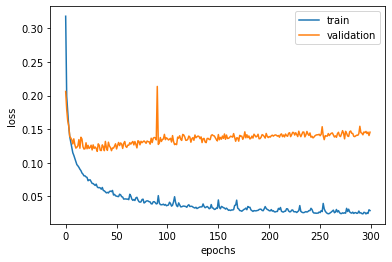

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

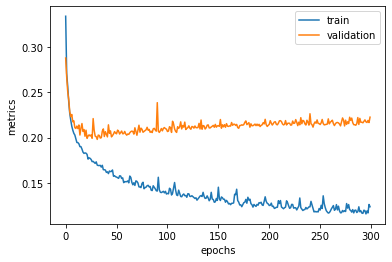

In [59]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [60]:
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
y_test = np.array(test_data['price'])
test_data = (test_data - mean) / std
x_test = np.array(test_data.drop('price', axis='columns'))
y_pred = model.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 13.66%


In [62]:
%load_ext tensorboard
%tensorboard --logdir lab2-logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 2s 7ms/step - loss: 0.4925 - mean_absolute_error: 0.4652 - val_loss: 0.3047 - val_mean_absolute_error: 0.3555
Epoch 2/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2927 - mean_absolute_error: 0.3376 - val_loss: 0.2460 - val_mean_absolute_error: 0.3107
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2508 - mean_absolute_error: 0.3052 - val_loss: 0.2194 - val_mean_absolute_error: 0.2946
Epoch 4/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2256 - mean_absolute_error: 0.2890 - val_loss: 0.2026 - val_mean_absolute_error: 0.2783
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2083 - mean_absolute_error: 0.2767 - val_loss: 0.1918 - val_mean_absolute_error: 0.2701
Epoch 6/300
203/203 [==============================] - 1s 4ms/step - loss: 0.1958 - mean_absolute_error: 0.2689 - val_loss: 0.1851 - val_mean_absolute_error: 0.2665
Epoch 7/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0780 - mean_absolute_error: 0.1826 - val_loss: 0.1180 - val_mean_absolute_error: 0.2005
Epoch 100/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0795 - mean_absolute_error: 0.1822 - val_loss: 0.1142 - val_mean_absolute_error: 0.1989
Epoch 101/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0763 - mean_absolute_error: 0.1808 - val_loss: 0.1158 - val_mean_absolute_error: 0.1998
Epoch 102/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0771 - mean_absolute_error: 0.1823 - val_loss: 0.1214 - val_mean_absolute_error: 0.2001
Epoch 103/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0761 - mean_absolute_error: 0.1802 - val_loss: 0.1155 - val_mean_absolute_error: 0.2010
Epoch 104/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0758 - mean_absolute_error: 0.1803 - val_loss: 0.1137 - val_mean_absolute_error: 0.1975
Epoch 105/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.1767 - val_loss: 0.1115 - val_mean_absolute_error: 0.1950
Epoch 198/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0696 - mean_absolute_error: 0.1753 - val_loss: 0.1116 - val_mean_absolute_error: 0.1955
Epoch 199/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0703 - mean_absolute_error: 0.1758 - val_loss: 0.1143 - val_mean_absolute_error: 0.1947
Epoch 200/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0704 - mean_absolute_error: 0.1752 - val_loss: 0.1121 - val_mean_absolute_error: 0.1939
Epoch 201/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0691 - mean_absolute_error: 0.1746 - val_loss: 0.1123 - val_mean_absolute_error: 0.1966
Epoch 202/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0699 - mean_absolute_error: 0.1755 - val_loss: 0.1127 - val_mean_absolute_error: 0.1958
Epoch 203/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0674 - mean_absolute_error: 0.1738 - val_loss: 0.1123 - val_mean_absolute_error: 0.1961
Epoch 296/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0674 - mean_absolute_error: 0.1752 - val_loss: 0.1079 - val_mean_absolute_error: 0.1958
Epoch 297/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0675 - mean_absolute_error: 0.1737 - val_loss: 0.1136 - val_mean_absolute_error: 0.1976
Epoch 298/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0678 - mean_absolute_error: 0.1749 - val_loss: 0.1076 - val_mean_absolute_error: 0.1939
Epoch 299/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0660 - mean_absolute_error: 0.1735 - val_loss: 0.1105 - val_mean_absolute_error: 0.1953
Epoch 300/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0669 - mean_absolute_error: 0.1743 - val_loss: 0.1090 - val_mean_absolute_error: 0.1952


In [64]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 2s 7ms/step - loss: 0.4129 - mean_absolute_error: 0.3385 - val_loss: 0.3017 - val_mean_absolute_error: 0.2862
Epoch 2/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2857 - mean_absolute_error: 0.2738 - val_loss: 0.2675 - val_mean_absolute_error: 0.2728
Epoch 3/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2561 - mean_absolute_error: 0.2540 - val_loss: 0.2526 - val_mean_absolute_error: 0.2548
Epoch 4/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2362 - mean_absolute_error: 0.2436 - val_loss: 0.2372 - val_mean_absolute_error: 0.2464
Epoch 5/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2178 - mean_absolute_error: 0.2347 - val_loss: 0.2136 - val_mean_absolute_error: 0.2307
Epoch 6/300
203/203 [==============================] - 1s 4ms/step - loss: 0.2044 - mean_absolute_error: 0.2251 - val_loss: 0.2088 - val_mean_absolute_error: 0.2331
Epoch 7/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0854 - mean_absolute_error: 0.1645 - val_loss: 0.1847 - val_mean_absolute_error: 0.2178
Epoch 100/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0932 - mean_absolute_error: 0.1692 - val_loss: 0.1466 - val_mean_absolute_error: 0.2082
Epoch 101/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0918 - mean_absolute_error: 0.1702 - val_loss: 0.1384 - val_mean_absolute_error: 0.1948
Epoch 102/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0842 - mean_absolute_error: 0.1641 - val_loss: 0.1277 - val_mean_absolute_error: 0.1904
Epoch 103/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0838 - mean_absolute_error: 0.1639 - val_loss: 0.1371 - val_mean_absolute_error: 0.1990
Epoch 104/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0864 - mean_absolute_error: 0.1665 - val_loss: 0.1304 - val_mean_absolute_error: 0.1906
Epoch 105/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0736 - mean_absolute_error: 0.1567 - val_loss: 0.1371 - val_mean_absolute_error: 0.1941
Epoch 198/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0737 - mean_absolute_error: 0.1578 - val_loss: 0.1387 - val_mean_absolute_error: 0.1952
Epoch 199/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0781 - mean_absolute_error: 0.1609 - val_loss: 0.1415 - val_mean_absolute_error: 0.1946
Epoch 200/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0731 - mean_absolute_error: 0.1570 - val_loss: 0.1300 - val_mean_absolute_error: 0.1922
Epoch 201/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0787 - mean_absolute_error: 0.1603 - val_loss: 0.1398 - val_mean_absolute_error: 0.2016
Epoch 202/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0774 - mean_absolute_error: 0.1605 - val_loss: 0.1358 - val_mean_absolute_error: 0.1948
Epoch 203/30

203/203 [==============================] - 1s 4ms/step - loss: 0.0705 - mean_absolute_error: 0.1554 - val_loss: 0.1365 - val_mean_absolute_error: 0.1958
Epoch 296/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0706 - mean_absolute_error: 0.1543 - val_loss: 0.1395 - val_mean_absolute_error: 0.1959
Epoch 297/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0745 - mean_absolute_error: 0.1578 - val_loss: 0.1290 - val_mean_absolute_error: 0.1950
Epoch 298/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0737 - mean_absolute_error: 0.1582 - val_loss: 0.1380 - val_mean_absolute_error: 0.1923
Epoch 299/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0712 - mean_absolute_error: 0.1554 - val_loss: 0.1361 - val_mean_absolute_error: 0.1988
Epoch 300/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0718 - mean_absolute_error: 0.1564 - val_loss: 0.1424 - val_mean_absolute_error: 0.1959


In [65]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 2s 8ms/step - loss: 0.4778 - mean_absolute_error: 0.4420 - val_loss: 0.2445 - val_mean_absolute_error: 0.3184
Epoch 2/300
203/203 [==============================] - 1s 5ms/step - loss: 0.3441 - mean_absolute_error: 0.3619 - val_loss: 0.2235 - val_mean_absolute_error: 0.2997
Epoch 3/300
203/203 [==============================] - 1s 5ms/step - loss: 0.2848 - mean_absolute_error: 0.3326 - val_loss: 0.2319 - val_mean_absolute_error: 0.3009
Epoch 4/300
203/203 [==============================] - 1s 5ms/step - loss: 0.2638 - mean_absolute_error: 0.3142 - val_loss: 0.2024 - val_mean_absolute_error: 0.2872
Epoch 5/300
203/203 [==============================] - 1s 5ms/step - loss: 0.2497 - mean_absolute_error: 0.3052 - val_loss: 0.1914 - val_mean_absolute_error: 0.2734
Epoch 6/300
203/203 [==============================] - 1s 5ms/step - loss: 0.2327 - mean_absolute_error: 0.2990 - val_loss: 0.1874 - val_mean_absolute_error: 0.2829
Epoch 7/30

203/203 [==============================] - 1s 5ms/step - loss: 0.1345 - mean_absolute_error: 0.2318 - val_loss: 0.1288 - val_mean_absolute_error: 0.2215
Epoch 51/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1328 - mean_absolute_error: 0.2313 - val_loss: 0.1313 - val_mean_absolute_error: 0.2162
Epoch 52/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1379 - mean_absolute_error: 0.2317 - val_loss: 0.1363 - val_mean_absolute_error: 0.2157
Epoch 53/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1332 - mean_absolute_error: 0.2325 - val_loss: 0.1431 - val_mean_absolute_error: 0.2203
Epoch 54/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1317 - mean_absolute_error: 0.2295 - val_loss: 0.1311 - val_mean_absolute_error: 0.2238
Epoch 55/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1418 - mean_absolute_error: 0.2306 - val_loss: 0.1450 - val_mean_absolute_error: 0.2159
Epoch 56/300
203/

203/203 [==============================] - 1s 5ms/step - loss: 0.1158 - mean_absolute_error: 0.2178 - val_loss: 0.1153 - val_mean_absolute_error: 0.2029
Epoch 100/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1171 - mean_absolute_error: 0.2209 - val_loss: 0.1180 - val_mean_absolute_error: 0.2079
Epoch 101/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1165 - mean_absolute_error: 0.2190 - val_loss: 0.1339 - val_mean_absolute_error: 0.2245
Epoch 102/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1202 - mean_absolute_error: 0.2221 - val_loss: 0.1304 - val_mean_absolute_error: 0.2298
Epoch 103/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1156 - mean_absolute_error: 0.2197 - val_loss: 0.1251 - val_mean_absolute_error: 0.2083
Epoch 104/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1114 - mean_absolute_error: 0.2176 - val_loss: 0.1203 - val_mean_absolute_error: 0.2140
Epoch 105/30

203/203 [==============================] - 1s 5ms/step - loss: 0.1222 - mean_absolute_error: 0.2192 - val_loss: 0.1136 - val_mean_absolute_error: 0.2023
Epoch 149/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1147 - mean_absolute_error: 0.2172 - val_loss: 0.1360 - val_mean_absolute_error: 0.2192
Epoch 150/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1085 - mean_absolute_error: 0.2149 - val_loss: 0.1130 - val_mean_absolute_error: 0.2049
Epoch 151/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1158 - mean_absolute_error: 0.2160 - val_loss: 0.1247 - val_mean_absolute_error: 0.2138
Epoch 152/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1216 - mean_absolute_error: 0.2189 - val_loss: 0.1073 - val_mean_absolute_error: 0.2011
Epoch 153/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1117 - mean_absolute_error: 0.2161 - val_loss: 0.1131 - val_mean_absolute_error: 0.2108
Epoch 154/30

203/203 [==============================] - 1s 5ms/step - loss: 0.1100 - mean_absolute_error: 0.2139 - val_loss: 0.1174 - val_mean_absolute_error: 0.2043
Epoch 198/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1054 - mean_absolute_error: 0.2143 - val_loss: 0.1205 - val_mean_absolute_error: 0.2230
Epoch 199/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1075 - mean_absolute_error: 0.2123 - val_loss: 0.1178 - val_mean_absolute_error: 0.2157
Epoch 200/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1047 - mean_absolute_error: 0.2121 - val_loss: 0.1223 - val_mean_absolute_error: 0.2200
Epoch 201/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1096 - mean_absolute_error: 0.2107 - val_loss: 0.1435 - val_mean_absolute_error: 0.2287
Epoch 202/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1118 - mean_absolute_error: 0.2115 - val_loss: 0.1163 - val_mean_absolute_error: 0.2117
Epoch 203/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0975 - mean_absolute_error: 0.2087 - val_loss: 0.1192 - val_mean_absolute_error: 0.2230
Epoch 247/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1066 - mean_absolute_error: 0.2138 - val_loss: 0.1310 - val_mean_absolute_error: 0.2223
Epoch 248/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1169 - mean_absolute_error: 0.2143 - val_loss: 0.1103 - val_mean_absolute_error: 0.2108
Epoch 249/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1076 - mean_absolute_error: 0.2104 - val_loss: 0.1195 - val_mean_absolute_error: 0.2281
Epoch 250/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1068 - mean_absolute_error: 0.2125 - val_loss: 0.1166 - val_mean_absolute_error: 0.2228
Epoch 251/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1113 - mean_absolute_error: 0.2128 - val_loss: 0.1130 - val_mean_absolute_error: 0.2176
Epoch 252/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0987 - mean_absolute_error: 0.2075 - val_loss: 0.1128 - val_mean_absolute_error: 0.2140
Epoch 296/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1025 - mean_absolute_error: 0.2091 - val_loss: 0.1147 - val_mean_absolute_error: 0.2159
Epoch 297/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1045 - mean_absolute_error: 0.2099 - val_loss: 0.1099 - val_mean_absolute_error: 0.2073
Epoch 298/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1034 - mean_absolute_error: 0.2094 - val_loss: 0.1212 - val_mean_absolute_error: 0.2200
Epoch 299/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0991 - mean_absolute_error: 0.2083 - val_loss: 0.1132 - val_mean_absolute_error: 0.2143
Epoch 300/300
203/203 [==============================] - 1s 5ms/step - loss: 0.1047 - mean_absolute_error: 0.2106 - val_loss: 0.1181 - val_mean_absolute_error: 0.2151


In [66]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 13.39%


In [67]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 13.21%


In [68]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 13.95%


In [69]:
%load_ext tensorboard
%tensorboard --logdir lab2-logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9816), started 0:36:17 ago. (Use '!kill 9816' to kill it.)